# Using time to model a linear trend

In this notebook, we show how to create a feature using time to capture the trend of a time series. We will use it to create a simple forecasts with a linear regression. We will also show how tree based models are unable to extrapolate into the future when there is trend.

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

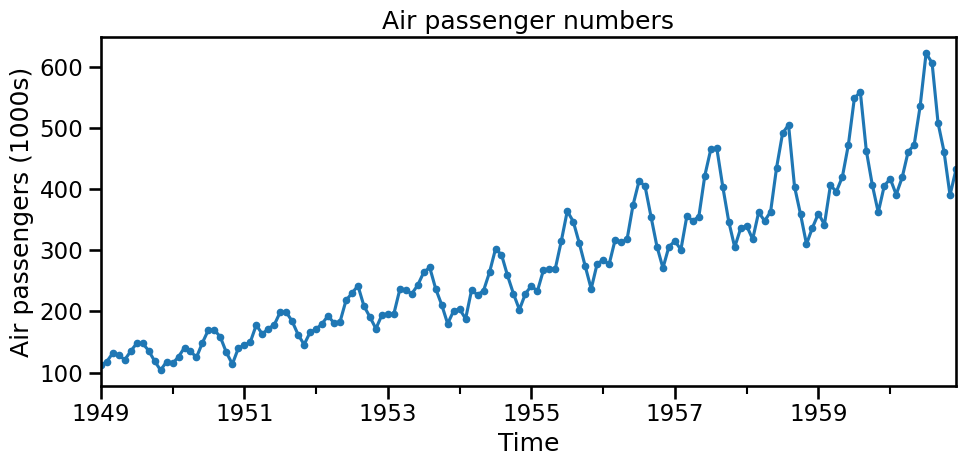

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Creating the time feature to capture trend (i.e., time since the start)

In [4]:
df = data.copy()

In [5]:
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Let's calculate the number of months since the start of the time series.

In [43]:
# How its look like? 
(df.index - df.index.min())[:10]

TimedeltaIndex([  '0 days',  '31 days',  '59 days',  '90 days', '120 days',
                '151 days', '181 days', '212 days', '243 days', '273 days'],
               dtype='timedelta64[ns]', name='ds', freq=None)

In [39]:

df["t"] = np.round((df.index - df.index.min()) / np.timedelta64(1, "M"))
df.head()

,y,t
ds,,
1949-01-01,112,0.0
1949-02-01,118,1.0
1949-03-01,132,2.0
1949-04-01,129,3.0
1949-05-01,121,4.0


In [41]:
df.tail()

,y,t
ds,,
1960-08-01,606,139.0
1960-09-01,508,140.0
1960-10-01,461,141.0
1960-11-01,390,142.0
1960-12-01,432,143.0


# TimeSince transformer from sktime

In [7]:
# Requires version 0.14.1 or greater of sktime.
from sktime.transformations.series.time_since import TimeSince

In [8]:
# Start with the original data again.
df = data.copy()

In [9]:
transformer = TimeSince(
    start=["1949-01-01", "1949-02-01"],  # A list of start dates.
    # If `None`, uses earliest time in dataframe.

    to_numeric=True,  # Convert output to integer or keep as time-like.
                      # Default is `True`
    
    freq="MS",  # Specify time series frequency if not specified in dataframe.
    # Default is `None` and it is inferred from the dataframe index.
    
    positive_only=False, # Set negative values to zero.
                         # Default is `False`
    
    keep_original_columns=False,  # Keep the other columns in the dataframe
                                  # after passing to `.transform()`.
                                  # Default is `False`
)

In [10]:
# fit for reach the transformer
transformer.fit(df)

TimeSince(freq='MS', start=['1949-01-01', '1949-02-01'])

Let's look at some of the attributes after fitting.

In [11]:
print(
    [
        transformer.start,
        transformer.freq,
    ]
)

[['1949-01-01', '1949-02-01'], 'MS']


Because we specified `start` there are no learned parameters from the data itself. When we use `.transform()` the transformer will compute for each date in `start`: `df.index - start_date` (i.e., the time since the specified start date) and convert this to an integer output.

In [12]:
# Make the transformation  
transformer.transform(df)

,time_since_1949-01-01 00:00:00,time_since_1949-02-01 00:00:00
ds,,
1949-01-01,0,-1
1949-02-01,1,0
1949-03-01,2,1
1949-04-01,3,2
1949-05-01,4,3
...,...,...
1960-08-01,139,138
1960-09-01,140,139
1960-10-01,141,140


If we do not specify the `start` dates then the transformer will **automatically use the earliest date** in the dataframe.

In [13]:
transformer = TimeSince()
transformer.fit_transform(df)

,time_since_1949-01-01 00:00:00
ds,
1949-01-01,0
1949-02-01,1
1949-03-01,2
1949-04-01,3
1949-05-01,4
...,...
1960-08-01,139
1960-09-01,140
1960-10-01,141


To keep the original columns we can set the `keep_original_columns` flag to `True`. 

In [14]:
transformer = TimeSince(keep_original_columns=True)
transformer.fit_transform(df)

,y,time_since_1949-01-01 00:00:00
ds,,
1949-01-01,112,0
1949-02-01,118,1
1949-03-01,132,2
1949-04-01,129,3
1949-05-01,121,4
...,...,...
1960-08-01,606,139
1960-09-01,508,140
1960-10-01,461,141


# Let's build a forecast with just the time feature

In [15]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In this example, we only have 1 exogenous feature (the time) and no features are built from the target variable. This makes the forecasting workflow simple in this case (no need to worry about direct or recursive forecasting), we'll show more complex examples later this section! Here, we just want to focus on how the single time feature impacts a forecast.

![](images/forecast_with_just_time.png)

In [16]:
# Create a new copy of the original data
df = data.copy()
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Note: In this example, where we are just creating a feature derived from the time index, it does not matter whether we create the time feature before or after splitting the data into a train and test set. This is because we cannot create look ahead bias with this feature, we are just using the time index to create a feature where we know its value in the past and the future. We would arrive at exactly the same dataframes being passed to the model during fitting and predicting irrespective of whether we create this feature first or split the data first.

Nevertheless, when building a feature engineering pipeline with other transformers which learn parameters from the training data we will want to split our data first, so we shall continue with this workflow.

Let's reserve the last 24 data points as hold out.

In [47]:
holdout_size = 24

df_train = df.iloc[:-holdout_size] 
df_test = df.iloc[-holdout_size:]

len(df_train), len(df_test)

(120, 24)

Create the time feature (i.e., the time since the start of the time series). We'll let the transformer infer the `start` parameter from our training data.

In [18]:
# Create an instance of the TimeSince transformer 
transformer = TimeSince(keep_original_columns=True, freq="MS")
# Fit the transformer on the data
transformer.fit(df_train)

# Create the time feature
df_train = transformer.transform(df_train)
df_test = transformer.transform(df_test)

In [19]:
# Sanity check
display(df_train.head())
display(df_train.tail())
display(df_test.head())

,y,time_since_1949-01-01 00:00:00
ds,,
1949-01-01,112,0
1949-02-01,118,1
1949-03-01,132,2
1949-04-01,129,3
1949-05-01,121,4


,y,time_since_1949-01-01 00:00:00
ds,,
1958-08-01,505,115
1958-09-01,404,116
1958-10-01,359,117
1958-11-01,310,118
1958-12-01,337,119


,y,time_since_1949-01-01 00:00:00
ds,,
1959-01-01,360,120
1959-02-01,342,121
1959-03-01,406,122
1959-04-01,396,123
1959-05-01,420,124


Create X and y for training and testing.

In [20]:
features = ["time_since_1949-01-01 00:00:00"] # the features columns
target = ["y"] # what we want to predict

# training set
y_train = df_train[target]   # train label 
X_train = df_train[features] # train features

# testing set
y_test = df_test[target]     # test label
X_test = df_test[features]   # test features

Create predictions for both the training and testing period.

In [21]:
# Create a linear-regression model
model = LinearRegression()

# train the model on the data
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)

Plot predictions.

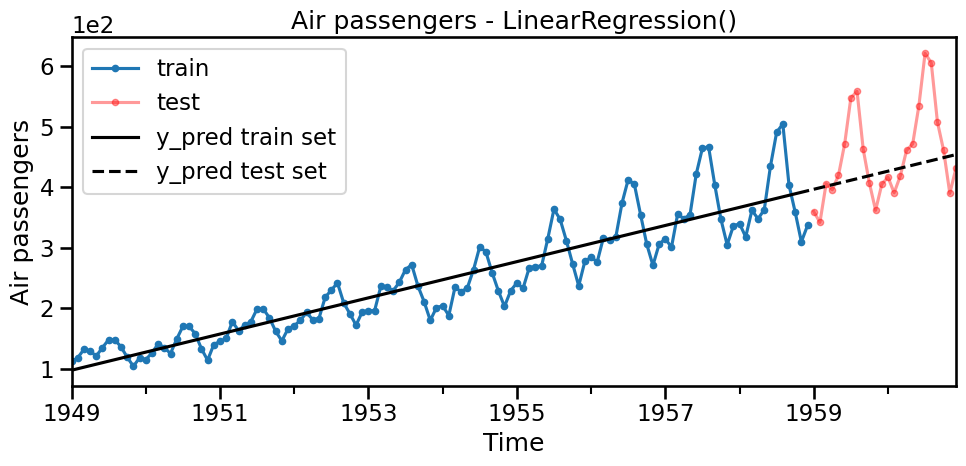

In [22]:
fig, ax = plt.subplots(figsize=[10, 5])

# Plot the train and test data
df_train[target].plot(ax=ax, marker=".", label="train")
df_test[target].plot(ax=ax, marker=".", color="r", label="test", alpha=0.4)

# Plot the train and test predictions
y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title(f"Air passengers - {model}")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

Let's see how this tree based models handle this feature.

In [23]:
# Create a model
model = DecisionTreeRegressor(max_depth=10)

# Train the model on the data 
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)

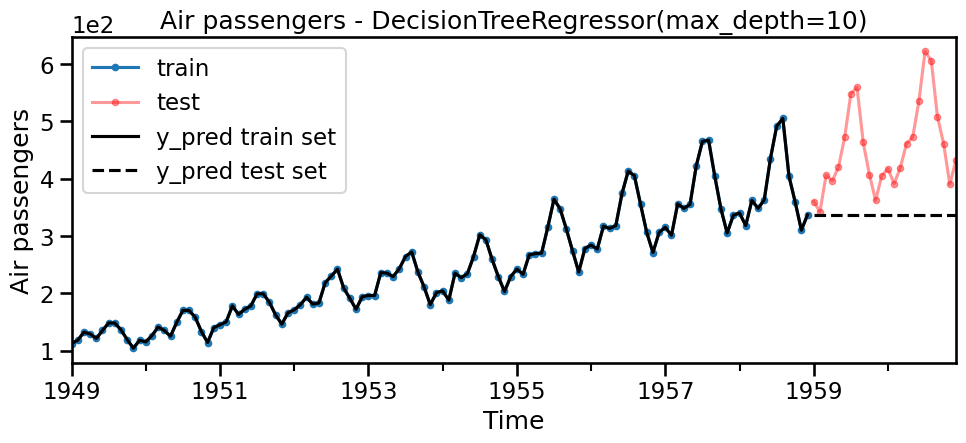

In [24]:
# Plot the data & predictions
fig, ax = plt.subplots(figsize=[10, 5])

# Plot the train & test data
df_train[target].plot(ax=ax, marker=".", label="train")
df_test[target].plot(ax=ax, marker=".", color="r", label="test", alpha=0.4)

# Plot the model prediction 
y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title(f"Air passengers - {model}")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

In [25]:
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)

c:\Users\97250\Desktop\sample_project_1\env\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


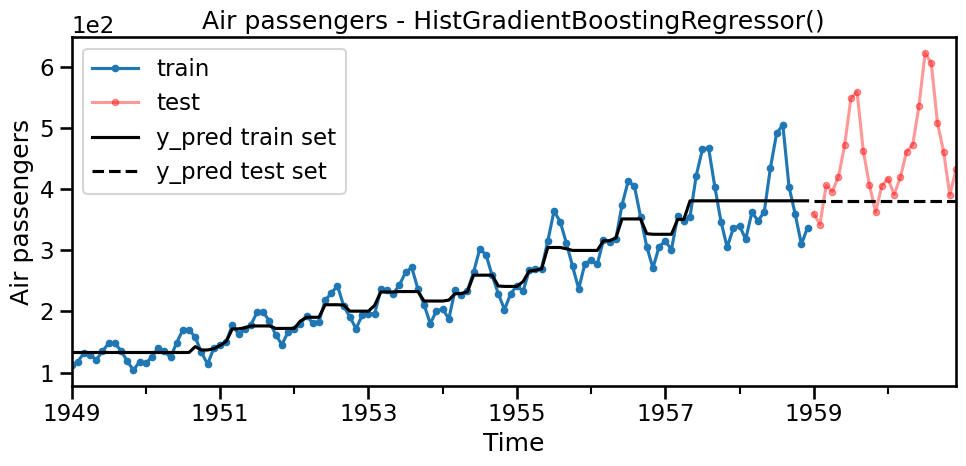

In [26]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker=".", label="train")
df_test[target].plot(ax=ax, marker=".", color="r", label="test", alpha=0.4)

y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title(f"Air passengers - {model}")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

# Let's build a forward looking forecast

In [27]:
# Create a new copy of the original data
df = data.copy()
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [28]:
forecast_start_point = df.index[-1] + pd.DateOffset(months=1)

# forecasting horizon
fh = pd.date_range(
    start=forecast_start_point,  # first period after the
                                 # end of our time series
    freq="MS",
    periods=12,  # forecast 12 periods into the future
)

# Create our features for our training and prediction periods

df_train = df  # Train over the whole dataset
df_predict = pd.DataFrame(index=fh)  # Predict over our forecast horizon

display(df_predict)


# This is all the dates that we want to predict into the future

""
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01
1961-06-01
1961-07-01
1961-08-01
1961-09-01
1961-10-01


Let's specify the start date manually just to show how it works.

We can actually pick any start date and we'll get *exactly* the
same results with linear and tree based models. This is because
this feature is just a measure of time from some reference time.
The choice of reference doesn't actually matter because
the time difference between any two time points is the same 
irrespective of our choice of reference time.


In [29]:
transformer = TimeSince(
    start=[pd.to_datetime("1970-02-01")],  # Pick a start date
                                           # far in future to
                                           # show it has no impact.
    freq="MS",
    keep_original_columns=True,
)

df_train = transformer.fit_transform(df_train)
df_predict = transformer.transform(df_predict)

In [30]:
display(df_train.head(), df_predict.head())

,y,time_since_1970-02-01 00:00:00
ds,,
1949-01-01,112,-253
1949-02-01,118,-252
1949-03-01,132,-251
1949-04-01,129,-250
1949-05-01,121,-249


,time_since_1970-02-01 00:00:00
1961-01-01,-109
1961-02-01,-108
1961-03-01,-107
1961-04-01,-106
1961-05-01,-105


In [31]:
features = ["time_since_1970-02-01 00:00:00"]
target = ["y"]

y_train = df_train[target]
X_train = df_train[features]

X_test = df_predict[features]

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, index=X_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, index=X_test.index)

Plot predictions

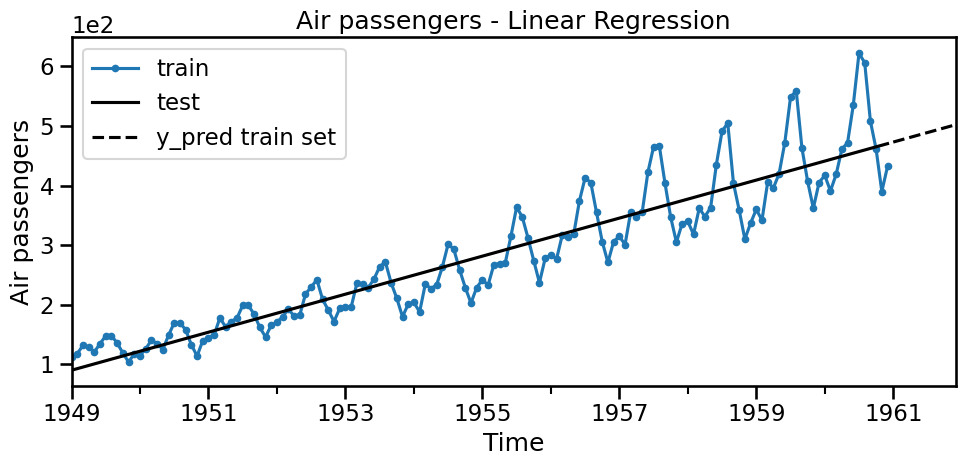

In [33]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker=".", label="train")
y_pred_train.plot(color="k", ax=ax)
y_pred_test.plot(color="k", ax=ax, linestyle="--")

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title("Air passengers - Linear Regression")
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.tight_layout()

We can see how specifying the start time has no effect on the model, we get the same linear curve! Hopefully this further reinforces the point that this feature cannot create look-ahead bias.

We can see how the time feature enables linear models to extrapolate a linear trend. We also see the limitation of tree-based models when the data contains trend. We will discuss how to handle trends when working with tree-based models in a later lecture.